### Overview

Building a model in tensorflow to classify cell type based on single cell RNA expression data, given a series of pre-labeled cells

Assumes a fairly clean dataset. VERY basic analysis and cleaning. Minimal data clean up or normalization. You could import data cleaned + normalized in R and use matrix here similarly.

Simple DNN model, as a starting point, will continue with more complex architectures.

### Data
raw data available from
https://support.10xgenomics.com/single-cell-gene-expression/datasets

taken from http://bit.ly/IAexpmat
analysis adapted from http://satijalab.org/seurat/Seurat_AlignmentTutorial.html

In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from functools import partial
from datetime import datetime

pd.set_option('display.max_rows', 20)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
file_path = os.path.join('../seurat_data/IntegratedAnalysis_ExpressionMatrices/pbmc_SeqWell.expressionMatrix.txt')

df = pd.read_csv(file_path, sep='\t')
df

,Bcell_1,Bcell_2,Bcell_3,Bcell_4,Bcell_5,...,Myeloid_1836,Myeloid_1837,Myeloid_1838,Myeloid_1839,Myeloid_1840
AAED1,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000
AAGAB,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000
AAK1,1.152871,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000
AAMP,1.152871,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000
AARS,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000
AASDHPPT,0.000000,0.634437,8.265317,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000
AATF,0.000000,1.268875,1.033165,1.24471,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000
ABCA1,2.305741,1.268875,0.000000,0.00000,0.000000,...,0.000000,7.117438,5.561735,0.0,4.948046
ABCA7,0.000000,0.000000,0.000000,0.00000,1.211681,...,0.000000,0.000000,0.000000,0.0,0.000000
ABCB1,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000


In [3]:
# get the transpose of the df, so rows are cells, and columns are genes
dft = df.T

In [4]:
dft

,AAED1,AAGAB,AAK1,AAMP,AARS,...,ZSWIM8,ZYG11B,ZYX,ZZEF1,ZZZ3
Bcell_1,0.000000,0.0,1.152871,1.152871,0.00000,...,0.000000,0.576435,0.576435,2.305741,0.000000
Bcell_2,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.634437
Bcell_3,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,2.066329,0.000000,0.000000
Bcell_4,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000
Bcell_5,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,7.270084,0.000000,0.000000,0.000000
Bcell_6,0.000000,0.0,0.000000,0.000000,1.34499,...,0.000000,0.000000,0.000000,1.344990,0.000000
Bcell_7,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,1.763357,0.000000,0.000000
Bcell_8,0.000000,0.0,0.000000,3.932363,0.00000,...,0.000000,0.000000,0.000000,1.966182,0.000000
Bcell_9,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000
Bcell_10,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000


## Basic Cleanliness Checks

In [5]:
# check sparseness of array

print('percent of DF non-zero: ' + str((df != 0).sum().sum() / (df.shape[0] * df.shape[1])))

percent of DF non-zero: 0.152034279462


In [6]:
# genes not expressed
# very few, we'll just ignore it

((df == 0).sum(axis=1) < 5).sum()

2

In [7]:
# mitochondria genes
# looks like they were already removed

df.columns[df.columns.str.startswith('MT-')]

Index([], dtype='object')

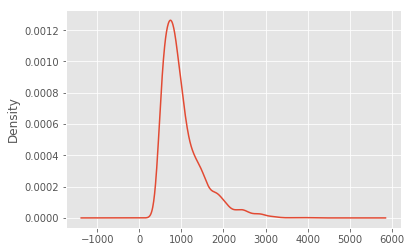

In [8]:
# number of genes expressed per cell

gene_number_expressed = (df > 0).sum(axis=0)
gene_number_expressed.plot(kind='kde')

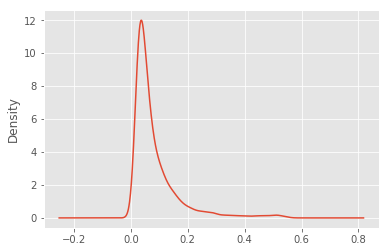

In [9]:
# see % of cells in which genes are expressed

gene_percent_expresed = (df > 0).sum(axis=1) / df.shape[0]
gene_percent_expresed.plot(kind='kde')

In [10]:
# top genes are sometimes worth ignoring (but they seem ok in this set)... lets see what they are
# todo - incorporate GO

gene_percent_expresed.sort_values()[-20:]

RPS19        0.523611
RPLP1        0.524356
RPS6         0.524356
RPL11        0.524505
RPS14        0.524654
HLA-A        0.529272
MT-RNR1      0.529867
HLA-C        0.530612
TMSB4X       0.535528
MTRNR2L8     0.537167
MTRNR2L1     0.537912
TMSB10       0.538507
MTRNR2L2     0.541040
FTL          0.542529
MTRNR2L12    0.542678
HLA-B        0.546998
TPT1         0.547147
MALAT1       0.549531
B2M          0.550127
MT-RNR2      0.550276
dtype: float64

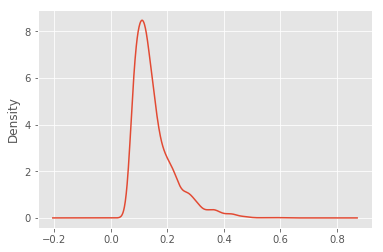

In [11]:
# see % of genes expressed in each cell

cell_percent_expressed = (df > 0).sum(axis=0) / df.shape[0]
cell_percent_expressed.plot(kind='kde')

9.79809921119 4.85554746298 33.6124500051


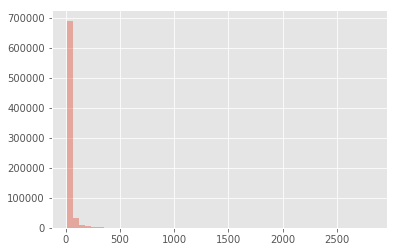

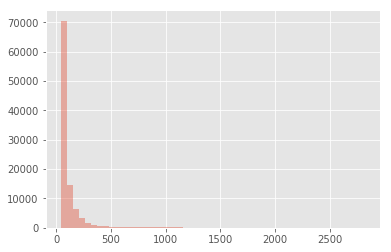

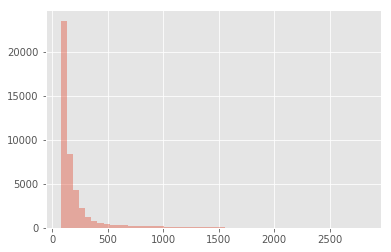

In [12]:
# check how normalized the counts are, by plotting a few graphs relative to mean and std. dev
# these give some cause for concern, since very large numbers might skew our results

avg_gene_expressions = df.values[df.values > 0]

avg_gene_expressions_mean = avg_gene_expressions.mean()
avg_gene_expressions_median = np.median(avg_gene_expressions)
avg_gene_expressions_sigma = np.std(avg_gene_expressions)

print(avg_gene_expressions_mean, avg_gene_expressions_median, avg_gene_expressions_sigma)

for i in [0,1,2]:
    plt.figure(i)
    sns.distplot(df.values[df.values > (avg_gene_expressions_mean + i * avg_gene_expressions_sigma)], kde=False)

In [13]:
# compare frequency with average expression value
# specifically, average of positive expression value (ignore 0 values)

gene_expression_average = df[df > 0].mean(axis=1)
gene_expression_average

AAED1          4.130760
AAGAB          4.637180
AAK1           4.453530
AAMP           4.211079
AARS           4.284473
AASDHPPT       5.144361
AATF           4.366869
ABCA1          6.729786
ABCA7          4.587700
ABCB1          6.475309
                 ...   
ZRANB1         4.637726
ZRANB2         5.859545
ZRSR2          4.670657
ZSCAN16-AS1    4.435248
ZSWIM6         4.261048
ZSWIM8         4.064739
ZYG11B         4.252516
ZYX            4.517731
ZZEF1          4.444709
ZZZ3           5.052086
Length: 6713, dtype: float64

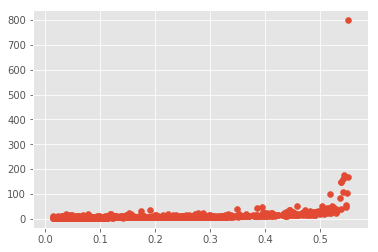

In [14]:
fig = plt.scatter(x=gene_percent_expresed, y=gene_expression_average)

(0, 200)

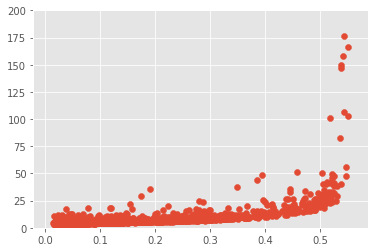

In [15]:
# we see that there is a slight correlation... 
# set the bounds so we can see better...

# cause for some concern, but nothing too horrible

fig = plt.scatter(x=gene_percent_expresed, y=gene_expression_average)
fig.axes.set_ylim(0, 200)

## Basic Model

In [16]:
columns = dft.columns.values

# create a type vector
type_vector = pd.Series(dft.index.map(lambda name: name.split('_')[0]))

# counts per type
type_counts = type_vector.groupby(type_vector).count()

print(type_counts)

type_to_int = list(type_counts.index)

print('type to int conversion:')
print(type_to_int)

Bcell       376
CD4         634
CD8         269
DC          104
Myeloid    1840
NK          471
dtype: int64
type to int conversion:
['Bcell', 'CD4', 'CD8', 'DC', 'Myeloid', 'NK']


In [17]:
# make a type -> number vector for the model
df_y = type_vector.apply(lambda cell_type: type_to_int.index(cell_type))

# save X matrix
df_X = dft.values

In [18]:
n_entries = len(df_X)

test_frac = 0.8
randos = np.random.permutation(n_entries)

train_count = int(n_entries * test_frac)

print('using %d of %d entries for training' % (train_count, n_entries))

train_i = randos[0:train_count]
test_i = randos[train_count:n_entries]

X_train = df_X[train_i]
y_train = df_y[train_i]

X_test = df_X[test_i]
y_test = df_y[test_i]

using 2955 of 3694 entries for training


In [19]:
# tensorflow time

tf.reset_default_graph()

In [20]:
he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, 
        n_hidden_layers=5, 
        n_hidden_neurons=100, 
        activation=tf.nn.elu,
        name=None,
        initializer=he_init,
        training=False,
        dropout_rate=None,
        batch_norm_momentum=None,
):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            if dropout_rate:
                inputs = tf.layers.dropout(inputs, dropout_rate, training=training)
            
            inputs = tf.layers.dense(inputs, n_hidden_neurons, kernel_initializer=initializer, name="hidden%d" % (layer + 1))
            
            if batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=batch_norm_momentum, training=training)
                
            inputs = activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

In [21]:
# CONSTRUCTION

from tensorflow.contrib.layers import dropout
from tensorflow.contrib.layers import batch_norm
# for projection in tensorboard
from tensorflow.contrib.tensorboard.plugins import projector

# CONFIG

n_inputs = len(columns)
n_outputs = len(type_counts)
n_hidden_neurons = 150
n_hidden_layers = 4

# training placeholder (affects batch, dropout)
training = tf.placeholder_with_default(False, shape=(), name='training')

# batch normalization
batch_momentum = 0.99

# dropout
# NOTE our data is sparse, and so effectively has drop-out built in, so unclear how useful dropout is here
dropout_rate = 0.5

# GRAPH

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

dnn_outputs = dnn(X, 
                  n_hidden_layers=n_hidden_layers,
                  n_hidden_neurons=n_hidden_neurons,
                  training=training,
                  dropout_rate=dropout_rate,
                  batch_norm_momentum=batch_momentum)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
tf.summary.scalar("loss", loss)

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1) 
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
tf.summary.scalar("acc", accuracy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

# logging / saving model

logdir = "tf_logs/run-{}".format(datetime.utcnow().strftime("%m%d_%H-%m"))
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

summary_merged = tf.summary.merge_all()

# TODO - create projection embedding, to visualize clustering of cells in tensorboard
#config = projector.ProjectorConfig()
#embedding = config.embeddings.add()
#embedding.tensor_name = logits.name
#embedding.metadata_path = os.path.join(logdir, 'metadata.tsv')
#projector.visualize_embeddings(summary_writer, config)

In [23]:
# EXECUTION

n_epochs = 100
batch_size = 50

n_train = len(X_train)
n_batches = n_train // batch_size

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            batch_start = iteration * batch_size
            batch_end = min(batch_start + batch_size, n_train)
            X_batch = X_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]

            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

            # save summary for tensorboard every 10th mini-batch
            if (iteration % 10 == 0):
                summary_str = summary_merged.eval(feed_dict={X: X_batch, y: y_batch, training: False})
                step = epoch * n_batches + iteration
                summary_writer.add_summary(summary_str, step)

        if (epoch % 10 == 0):
            # save our model for tensorboard + check accuracy
            saver.save(sess, os.path.join(logdir, './ssrna_model.ckpt'))
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch, training: False})
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test, training: False})
            print(epoch, "train acc:", acc_train, "test acc:", acc_test)
            
    final_acc = accuracy.eval(feed_dict={X: df_X, y: df_y}, session=sess)
    print('Final accuracy: %f' % (final_acc))


0 train acc: 0.62 test acc: 0.660352
10 train acc: 0.92 test acc: 0.85115
20 train acc: 0.92 test acc: 0.856563
30 train acc: 0.96 test acc: 0.856563
40 train acc: 0.96 test acc: 0.857916
50 train acc: 1.0 test acc: 0.876861
60 train acc: 1.0 test acc: 0.886333
70 train acc: 1.0 test acc: 0.864682
80 train acc: 1.0 test acc: 0.903924
90 train acc: 1.0 test acc: 0.883627
Final accuracy: 0.978614


In [ ]:
# todo - analyze model on another PBMC set